In [1]:
require(tidyverse)

Loading required package: tidyverse

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Hypothesis Testing

In [2]:
# chi-squared testing
prop.test(
    n = c(243, 277), 
    x = c(5, 8), 
    alternative = "less", 
    conf.level = .95
)


	2-sample test for equality of proportions with continuity correction

data:  c(5, 8) out of c(243, 277)
X-squared = 0.10479, df = 1, p-value = 0.3731
alternative hypothesis: less
95 percent confidence interval:
 -1.00000000  0.01788103
sample estimates:
    prop 1     prop 2 
0.02057613 0.02888087 


In [3]:
# student's t testing
t.test(
    x = c(rep(2499, 28), rep(890, 337), rep(0, 2274)), 
    y = c(rep(2499, 35), rep(890, 328), rep(0, 2189))
)


	Welch Two Sample t-test

data:  c(rep(2499, 28), rep(890, 337), rep(0, 2274)) and c(rep(2499, 35), rep(890, 328), rep(0, 2189))
t = -0.77275, df = 5147.6, p-value = 0.4397
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -30.04414  13.05544
sample estimates:
mean of x mean of y 
 140.1675  148.6618 


## Sample Size Inference

In [4]:
# batch sample size inference
mde_to_sample_size = function(mde, base = 0.65) {
    power_prop = power.prop.test(
        p1 = base, 
        p2 = base + mde, 
        power = .8, 
        sig.level = .1,
        alternative = "one.sided"
    )
    floor(power_prop$n)
}

# display
rbind(
    (1:5)*.025, 
    map_dbl((1:5)*.025, mde_to_sample_size, base = 0.3)
) %>% t() %>% as_tibble()

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


V1,V2
<dbl>,<dbl>
0.025,3098
0.050,790
0.075,357
0.100,204
0.125,132


In [3]:
# for prop.test
power.prop.test(
    p1 = 0.6, 
    p2 = 0.65, 
    power = .8, 
    sig.level = .1,
    alternative = 'one'
)


     Two-sample comparison of proportions power calculation 

              n = 844.3304
             p1 = 0.6
             p2 = 0.65
      sig.level = 0.1
          power = 0.8
    alternative = one.sided

NOTE: n is number in *each* group


t-test params

$\delta = \mu_1 - \mu_2$

$sd = \sqrt{\frac{1/m + 1/n}{m+n-2} (S_X^2 + S_Y^2) }$

In [6]:
# for t.test
power.t.test(
    delta = .2,
    sd = 1,
    power = .8,
    sig.level = .1
)


     Two-sample t test power calculation 

              n = 309.8065
          delta = 0.2
             sd = 1
      sig.level = 0.1
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


## Conf. Interval for Conversite Rates

$x_i \sim \text{Bernoulli}(p)$

$\text{sd}(\bar{x}) = \sqrt{\text{var}(x_i)/n}$

In [7]:
ci_width_95_for_conversion = function(p = 0.02, sample_sizes = (1:10) * 500) {
    # display
    cat('confidence interval for mean = ', p, " under different sample sizes.\n", sep = "")
    cat(rep('-', 20))  
    # sd of mean
    sd_x_mean = sqrt(p * (1 - p) / sample_sizes)
    # ci width of mean
    ci_width_95 = sd_x_mean * 1.96
    # display
    rbind(sample_sizes, ci_width_95) %>% t() %>% as_tibble() %>% mutate(
        # ci_width_95 = scales::label_percent(accuracy = .01)(ci_width_95)
        ci_width_95 = round(ci_width_95, digits = 4)
    )
}

In [8]:
ci_width_95_for_conversion(p = 0.85, sample_sizes = (1:10)*100)

confidence interval for mean = 0.85 under different sample sizes.
- - - - - - - - - - - - - - - - - - - -

sample_sizes,ci_width_95
<dbl>,<dbl>
100,0.0700
200,0.0495
300,0.0404
400,0.0350
500,0.0313
600,0.0286
700,0.0265
800,0.0247
900,0.0233


## Sample Size for ASP via Monte Carlo

In [9]:
# --------------- SEP ---------------
price_power_analysis <- 
    function(prices, conversion_rates, mean_lift, sig_level = .1, power = .8) {
    # monte carlo settings
    SAMPLE_SIZE = 100000
    price_vector = c(0, prices)
    conversion_vector = c(1 - sum(conversion_rates), conversion_rates)
    # simulate sales for a population
    sales_vector = sample(price_vector, SAMPLE_SIZE, replace=TRUE, prob=conversion_vector)

    # assumed mean and standard deviation
    sample_mean = mean(sales_vector)
    sample_sd = sd(sales_vector)
    cat("ASP mean:", sample_mean, '\n')
    cat("ASP std:", sample_sd, '\n')
    cat(rep('-', 20), '\n')
    
    # sample size
    power.t.test(
        delta = mean_lift,
        sd = sample_sd,
        sig.level = sig_level, 
        power = power, 
        alternative = "one.sided"
    )
}

In [10]:
price_power_analysis(c(2499, 800), c(0.013, 0.11), mean_lift = 15)

ASP mean: 118.903 
ASP std: 363.4044 
- - - - - - - - - - - - - - - - - - - - 



     Two-sample t test power calculation 

              n = 5292.151
          delta = 15
             sd = 363.4044
      sig.level = 0.1
          power = 0.8
    alternative = one.sided

NOTE: n is number in *each* group


## ANOVA

In [11]:
# generate data
df_conv = as_tibble(rbind(
    cbind(rep('a/00', 2238), c(rep(1, 15), rep(0, 2238 - 15))),
    cbind(rep('b/31', 2415), c(rep(1, 3), rep(0, 2415 - 3))),
    cbind(rep('c/91', 2295), c(rep(1, 1), rep(0, 2295 - 1))),
    cbind(rep('d/181', 6602), c(rep(1, 6), rep(0, 6602 - 6)))
))
names(df_conv) = c('group', 'res')

In [12]:
anova_conv = aov(res ~ group, df_conv)
summary(anova_conv)

               Df Sum Sq  Mean Sq F value   Pr(>F)    
group           3  0.064 0.021342   11.62 1.34e-07 ***
Residuals   13546 24.890 0.001837                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

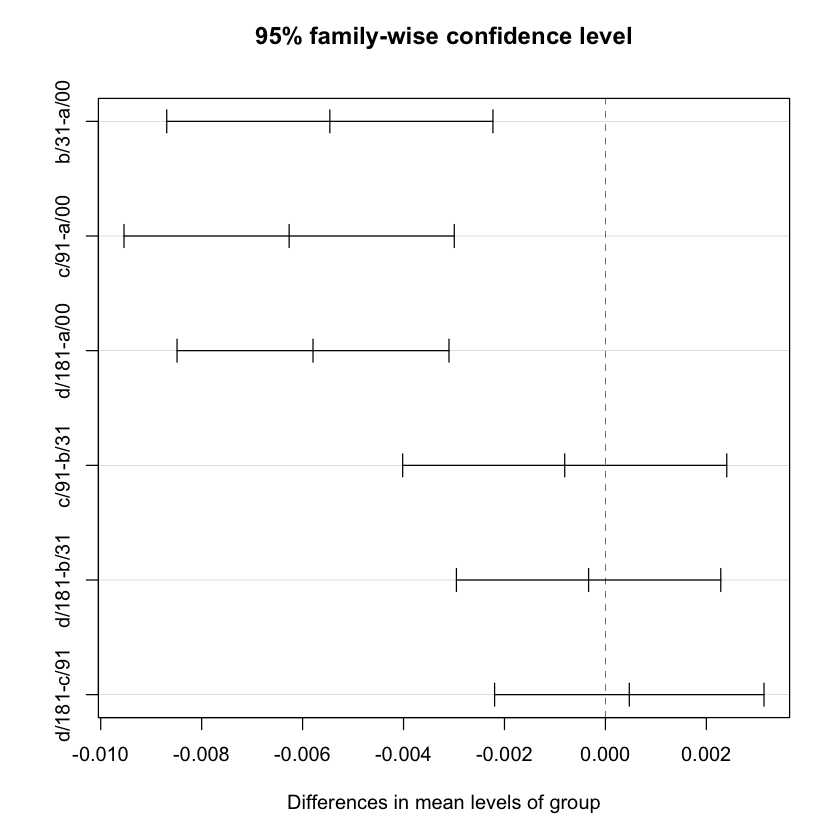

In [13]:
plot(TukeyHSD(anova_conv))

## Target Lower Bound for Conversion Rates

Ref: https://rdrr.io/cran/Ryacas/f/vignettes/getting-started.Rmd

Suppose our target conversion rate is at least 0.05, and we want a test to determine whether a specific media channel could meet the requirement.

Since the test is done on limited a sample size, we should aim at a higher conversion rate, which is calculated in the formula below.

$lb = p - \sqrt{\frac{p (1 - p)}{n}} \times \Phi^{-1} (1 - q)$

where p is the target conversion rate, and q is the probability that true conversion is less then lb.

I've done a Python version like this,

```python
import sympy
from scipy.stats import norm


def exp_conversion_fn(lb=.05, q=.2):
    """ returns a function which accepts sample size 
    and returns experiment conversion rate target
    
    lb -- lower bound of conversion rate
    q -- quantile of the lower bound
    """
    p = sympy.symbols("p", positive=True)
    n = sympy.symbols("n", positive=True, integer=True)
    eq = p - sympy.sqrt(p * (1 - p) / n) * norm.ppf(1 - q) - lb
    # simplify result formulas with factor
    fn = sympy.factor(sympy.solve(eq, p))
    return sympy.lambdify(n, fn[1])
    
fn = exp_conversion_fn()

for n in range(100, 550, 50):
    p = fn(n)
    print(f"target conversion for sample size {n}:{p: .4f}")
```

In [17]:
require(Ryacas)

In [15]:
# get p given other variables
conversion_test_target = function(lb = .05, q = .2, n = 100) {
    p = ysym("p")
    # remove sqrt before solving
    eq = p^2 - 2 * lb * p + lb^2 - qnorm(p = 1 - q)^2 * p * (1 - p) / n
    solve(eq, c("p"))[1, ] %>% y_rmvars() %>% as_r()
}

In [20]:
# p for various n
for (n in (1:5) * 100) {
    cat('target conversion for sample size', n, ':', 
        conversion_test_target(n = n), '\n')
}

target conversion for sample size 100 : 0.07171515 
target conversion for sample size 200 : 0.06463249 
target conversion for sample size 300 : 0.06169065 
target conversion for sample size 400 : 0.05999317 
target conversion for sample size 500 : 0.05885858 
